In [191]:
# CELL to import and set up matplotlib for the entire notebook
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.dpi"] = 96
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams["figure.figsize"] = (6,6)
%matplotlib widget
%matplotlib notebook

# Tension spring stiffness single parameter

In [1]:
from symulathon import Simulation
import numpy as np
from tqdm import tqdm
from simulation_functions import simulate

In [15]:
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

k_values = np.linspace(0.01, 40, 200)
g_values = []
dgdp_values = []
for k in tqdm(k_values):
    bp = simulate(k, 0.1, DIFF_FRAMES)
    g_values.append(bp.get_g())
    dgdp_values.append(bp.get_dgdp()[0])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (k_values[i+1] - k_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:43<00:00,  1.42s/it]


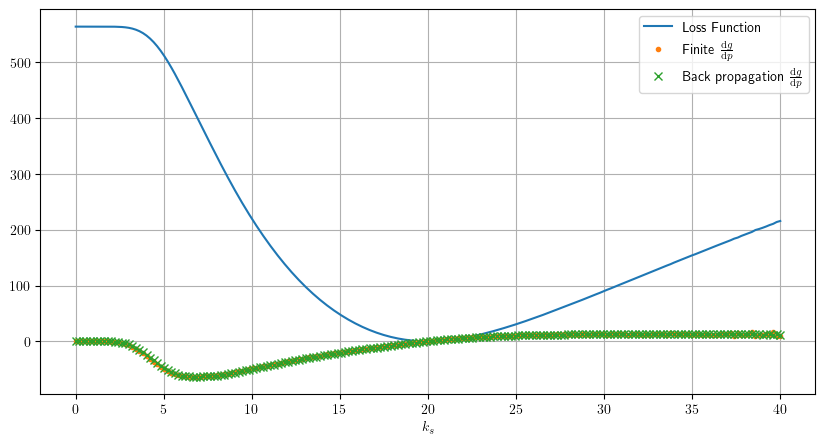

Finished succesfully


In [16]:
plt.close()
plt.plot(k_values, g_values, "-", label="Loss Function")
plt.plot(k_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
plt.plot(k_values, dgdp_values, "x", label="Back propagation $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
error = abs(np.array(dgdp_finite) - np.array(dgdp_values))
# plt.errorbar(k_values, dgdp_values, yerr = error)
plt.legend()
plt.xlabel("$k_s$")
#plt.ylim(-70,30)
plt.grid()
plt.show()
plt.savefig('figures/test.pdf')
print("Finished succesfully")

# Tilt angle single parameter

In [13]:
from symulathon import Simulation
from simulation_functions import newton_iteration, get_user_weather_graphics
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [17]:
k = 20
k_bend = 0.1
graphics=True
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def simulate(tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation


INFO: Initializing raylib 4.6-dev
INFO: Supported raylib modules:
INFO:     > rcore:..... loaded (mandatory)
INFO:     > rlgl:...... loaded (mandatory)
INFO:     > rshapes:... loaded (optional)
INFO:     > rtextures:. loaded (optional)
INFO:     > rtext:..... loaded (optional)
INFO:     > rmodels:... loaded (optional)
INFO:     > raudio:.... loaded (optional)
INFO: DISPLAY: Device initialized successfully
INFO:     > Display size: 1920 x 1080
INFO:     > Screen size:  1600 x 900
INFO:     > Render size:  1600 x 900
INFO:     > Viewport offsets: 0, 0
INFO: GLAD: OpenGL extensions loaded successfully
INFO: GL: Supported extensions count: 389
INFO: GL: OpenGL device information:
INFO:     > Vendor:   NVIDIA Corporation
INFO:     > Renderer: NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
INFO:     > Version:  3.3.0 NVIDIA 535.104.05
INFO:     > GLSL:     3.30 NVIDIA via Cg compiler
INFO: GL: VAO extension detected, VAO functions loaded successfully
INFO: GL: NPOT textures extension detected, full NP

In [18]:
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()

angle_values = np.linspace(240, 300, 300)
g_values = []
dgdp_values = []
for angle in tqdm(angle_values):
    bp = simulate(np.radians(angle), DIFF_FRAMES)
    g_values.append(bp.get_g())
    dgdp_values.append(bp.get_dgdp()[3])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (angle_values[i+1] - angle_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  0%|          | 0/300 [00:00<?, ?it/s]

INFO: VAO: [ID 4] Mesh uploaded successfully to VRAM (GPU)
INFO: FILEIO: [../resources/warning.png] File loaded successfully
INFO: IMAGE: Data loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: TEXTURE: [ID 5] Texture loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: VAO: [ID 5] Mesh uploaded successfully to VRAM (GPU)
INFO: FILEIO: [../resources/warning.png] File loaded successfully
INFO: IMAGE: Data loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: TEXTURE: [ID 6] Texture loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: VAO: [ID 6] Mesh uploaded successfully to VRAM (GPU)
INFO: FILEIO: [../resources/warning.png] File loaded successfully
INFO: IMAGE: Data loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: TEXTURE: [ID 7] Texture loaded successfully (800x600 | R8G8B8 | 1 mipmaps)
INFO: VAO: [ID 7] Mesh uploaded successfully to VRAM (GPU)
INFO: FILEIO: [../resources/warning.png] File loaded successfully
INFO: IMAGE: Data loaded successfully (800x600 | R

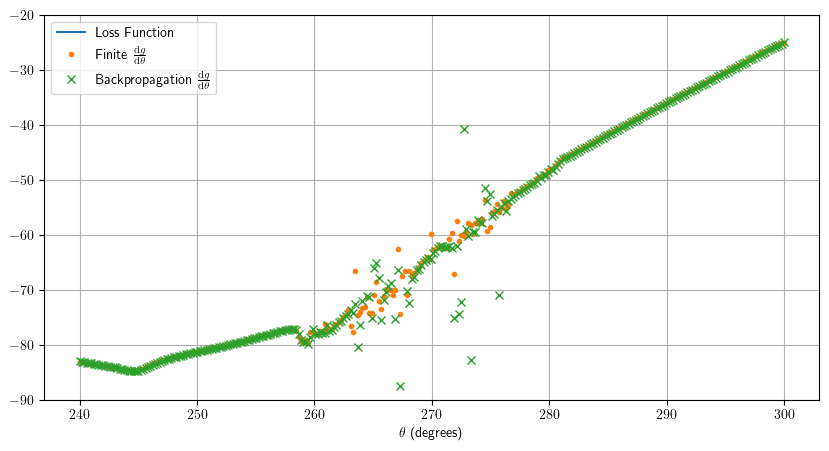

Finished succesfully


In [20]:
plt.close()
plt.plot(angle_values, g_values, "-", label="Loss Function")
plt.plot(angle_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")
plt.plot(angle_values, dgdp_values, "x", label="Backpropagation $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")

plt.legend()
plt.xlabel("$\\theta$ (degrees)")
plt.ylim(-90,-20)
plt.grid()
plt.show()
plt.savefig("figures/test.pdf")
print("Finished succesfully")

# 2 diferential parameters: tension and bending spring stiffness

In [4]:
from symulathon import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from simulation_functions import simulate
from concurrent import futures

In [198]:
# Initialize important constant variables
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

# Define the region studied
n_points = 10
k_values = np.linspace(16, 24, n_points)
k_bend_values = np.linspace(0, 0.5, n_points)
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
g_values = np.zeros(X.shape)
dgdk_values = np.zeros(X.shape)
dgdk_bend_values = np.zeros(X.shape)

# Multi-core solution
pool = futures.ProcessPoolExecutor()
for i in tqdm(range(len(k_values))):
    k_values_i = [k_values[i]] * len(k_bend_values)
    DIFF_FRAMES_i = [DIFF_FRAMES] * len(k_bend_values)
    bps = pool.map(simulate, k_values_i, k_bend_values, DIFF_FRAMES_i)
    for j, bp in enumerate(bps):
        dgdp = bp.get_dgdp()
        dgdk_values[i][j] = dgdp[0]
        dgdk_bend_values[i][j] = dgdp[1]
        g_values[i][j] = bp.get_g()

  0%|          | 0/10 [00:00<?, ?it/s]

In [199]:
# Finite differences
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
dk = k_values[1]-k_values[0]
dk_bend = k_bend_values[1]-k_bend_values[0]
g_values = np.array(g_values)
dgdk_values_finite, dgdk_bend_values_finite = np.gradient(g_values, dk, dk_bend)

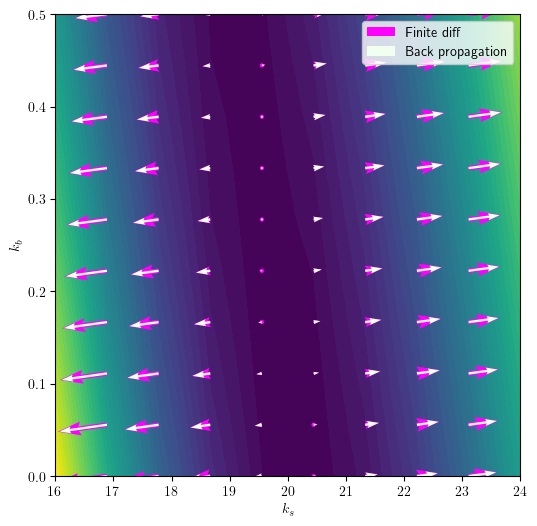

In [211]:
# Plotting
plt.close()

scale = (k_values[-1] - k_values[0]) / (k_bend_values[-1] - k_bend_values[0])
plt.contourf(X, Y, g_values, levels=50)
#plt.contour(X, Y, g_values, levels=20, cmap="Greys")
plt.quiver(X, Y, dgdk_values_finite*scale, dgdk_bend_values_finite/scale,
           label="Finite diff", angles='xy', scale_units="xy", color="magenta", width=0.01)
plt.quiver(X, Y, dgdk_values*scale, dgdk_bend_values/scale,
           label="Back propagation", angles='xy',scale_units="xy", color="honeydew",width=0.005)

plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$k_b$")
plt.show()


In [10]:
# save the data to disk
np.save("data/x_data.npy", X)
np.save("data/y_data.npy", Y)
np.save("data/g_data.npy", g_values)
np.savez("data/dgdk_data.npy",
         dgdk_values,
         dgdk_bend_values,
         dgdk_values_finite,
         dgdk_bend_values_finite)

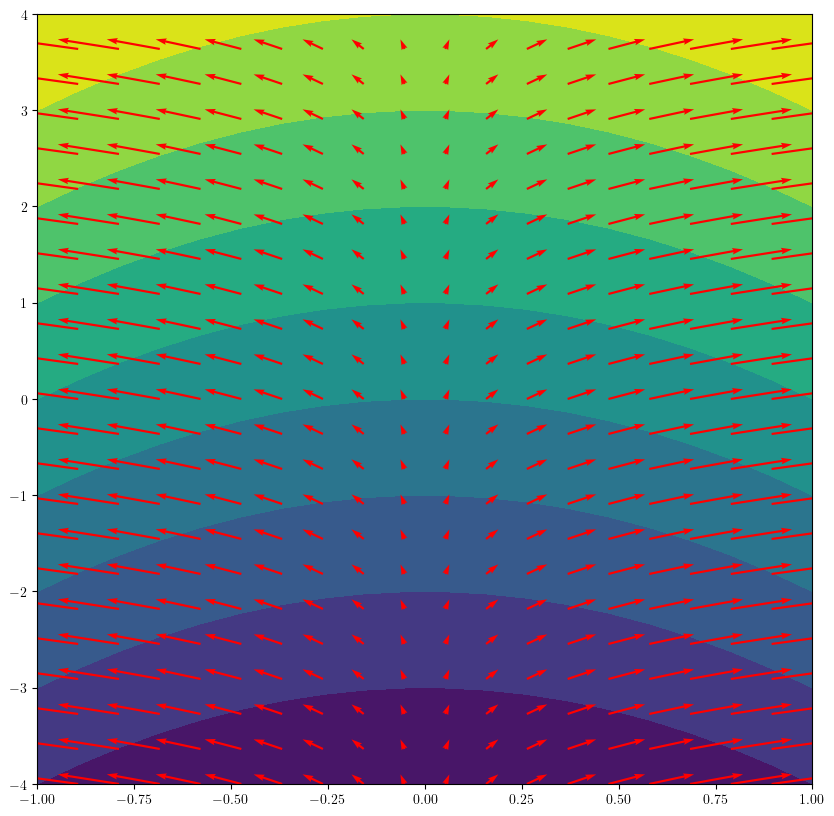

In [129]:
plt.close()
n_points = 20
x_values = np.linspace(-1, 1, n_points)
y_values = np.linspace(-4, 4, n_points+3)
X, Y = np.meshgrid(x_values, y_values, indexing='ij')
Z = X**2 + Y
dx = x_values[1] - x_values[0]
dy = y_values[1] - y_values[0]
grad_x, grad_y = np.gradient(Z, dx, dy)
plt.contourf(X, Y, Z, levels=10)
plt.quiver(X, Y, grad_x, grad_y, color='r', angles="xy", scale=10, scale_units='xy')
plt.show()